#비지도 학습

비지도 학습 : 입력 정보만 사용함

종류 - 클러스터링, 차원 압축, 이상 감지..

그 중 클러스터링을 하겠다!

###클러스터링
입력 데이터가 비슷한 것 끼리 클래스로 나누는 것

- 클래스 : 단순한 라벨
- 클러스터 : 분포의 특징

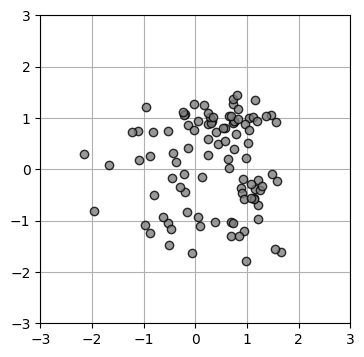

In [ ]:
# ----------------- 리스트 9-1-(1)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성 --------------------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기 ------------------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)


###K-means 기법

미리 분할할 클러스터의 수 K를 결정

필요한 두 변수

- 클러스터의 중심 벡터(뮤) : 클러스터의 중심 위치를 나타냄
- 클러스터 지시변수 필요(R) : 각 데이터 점이 어떤 클러스터에 속하는지 나타냄

K-means 실행 순서

1. 클러스터의 중심 벡터에 적절한 값 제공
2. 현 시점에서 중심 벡터를 바탕으로 클래스 지시 변수 결정
3. 현 시점에서 클래스 지시변수로 중심 벡터 갱신

###1. 변수의 준비와 초기화
클러스터 중심의 차원은 입력 차원에 종속

중심 벡터에는 최초에 적당한 초기값 제공

클래스 지시 변수는 각 데이터가 어느 클래스에 속해 있는지를 1-of-K 부호화법으로 나타냄

1-of-K 부호화법이란?

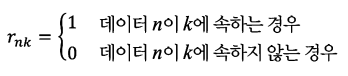

모든 데이터를 정리하여 행렬로 나타낸 중심차원

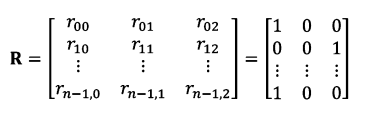

In [ ]:
# ----------------- 리스트 9-1-(2)
# Mu 및 R 초기화 -----------------------------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A)
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B)

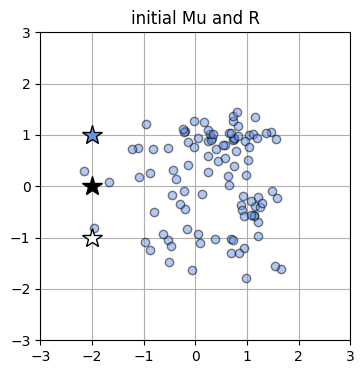

In [ ]:
# ----------------- 리스트 9-1-(3)
# 데이터를 그리는 함수 ---------------------------
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

###2. R의 갱신
각 데이터 점을 가장 중심이 가까운 클러스터에 넣음

계산은 제곱근의 계산을 생략한 제곱 거리를 비교하여 결정 -> 모든 데이터에 대해 수행

이 절차를 실행하면 데이터 점이 각 클래스에 배정됨

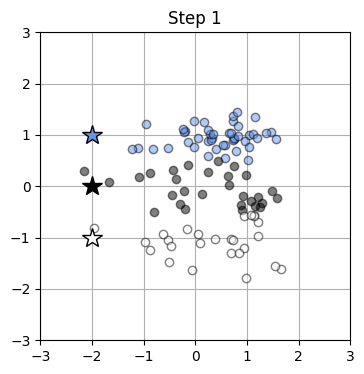

In [ ]:
# ----------------- 리스트 9-1-(4)
# r을 결정한다 (Step 1) -----------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# ------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

###3. 뮤의 갱신

각 클러스터에 속하는 데이터의 중심을 새로운 뮤로 바꿈


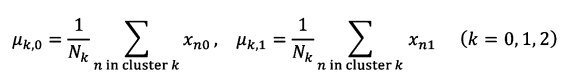

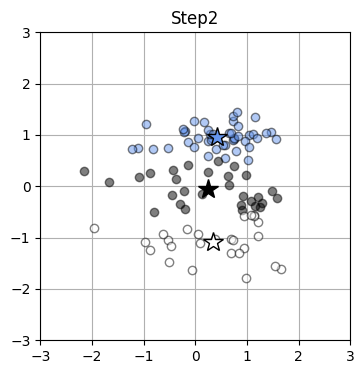

In [ ]:
# ----------------- 리스트 9-1-(5)
# Mu 결정 (Step 2) ----------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# ------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

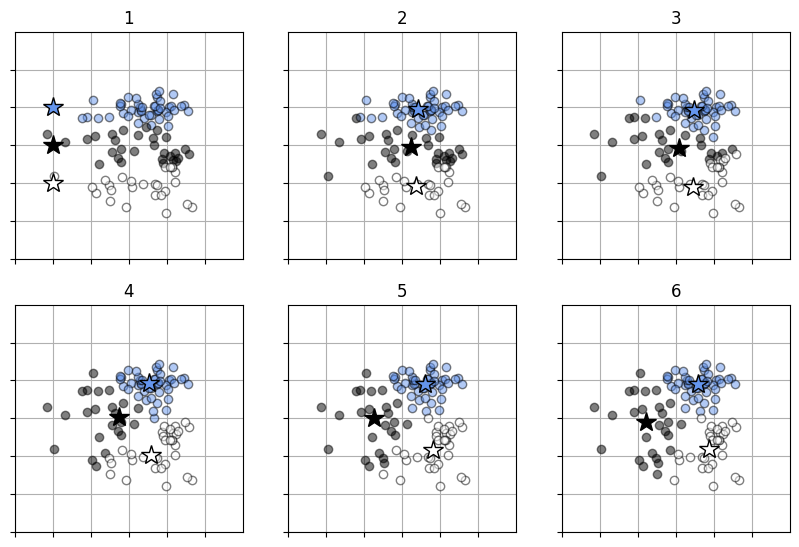

In [ ]:
# ----------------- 리스트 9-1-(6)
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

뮤가 각각의 분포의 중심으로 이동

###왜곡 척도
cost 함수

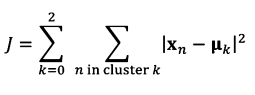

In [ ]:
# ----------------- 리스트 9-1-(7)
# 목적 함수 ----------------------------------
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


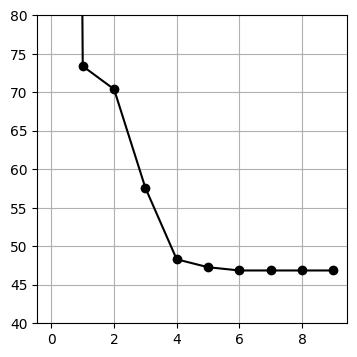

In [ ]:
# ----------------- 리스트 9-1-(8)
# Mu와 R의 초기화
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

왜곡 척도는 반복 계산을 통해 계속 감소

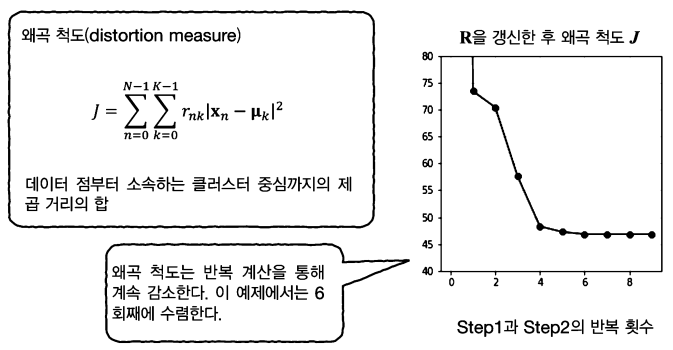

K-means로 얻는 해는 초기값 의존성 존재, 처음 뮤에 무엇을 할당하는지에 따라 결과가 달라짐

-> 다양한 뮤에서 시작하여 가장 왜곡 척도가 작은 결과를 사용

-> 뮤를 먼저 정했지만 R을 먼저 결정해도 됨

###가우시안 혼합 모델
가우시안 분포가 여러 개 혼합된 클러스터링 알고리즘, 자연적인 현상을 표현하기에 좋은 모델

###확률적 클러스터링
데이터 점들이 모두 같은 클러스터에 포함되더라도 결정경계에 있는 경우 모호성을 표현해주기 위해 확률의 개념을 포함



관찰은 못했지만 데이터에 영향을 준 변수 : 잠재 변수

2개의 특징으로 분류하였지만 클러스터가 3개 존재 -> 실은 적어도 세 가지의 변종, 관찰하지 못한 특징이 하나 더 존재

- 관찰할 수 없는 Z의 추정치가 감마이다. -> 어떤 클래스에 얼마나 기여하고 있는가 : 부담률

=> 확률적 클러스터링은 데이터의 배후에 숨어있는 잠재 변수 Z를 확률적으로 감마로 추정하는 것

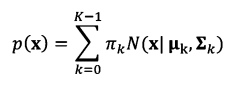

위 식은 평균 뮤, 공분산행렬 시그마의 2차원 가우스 함수, 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 K개 겹친 분포를 나타냄

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# ----------------- 리스트 9-2-(1)
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

입력 데이터 x는 N X D의 행렬, 혼합 계수 pi는 길이 K의 벡터, 중심벡터 mu는 K X D의 행렬, 공분산행렬 sigma는 K X D X D의 3차원 배열 변수

In [ ]:
# ----------------- 리스트 9-2-(2)
# 가우스 함수 -----------------------------
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

In [ ]:
# ----------------- 리스트 9-2-(3)
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [ ]:
# ----------------- 리스트 9-2-(4)
# 혼합 가우시안 모델 ----------------------
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [ ]:
# ------------ 리스트 9-2-(5)
# test -------------------------------
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:
# ----------------- 리스트 9-2-(6)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시 ----------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시 ---------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0,( xn * xn, 1)), np.reshape(xx1, (xn* xn, 1))]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn,xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3, color='blue', edgecolor='black')


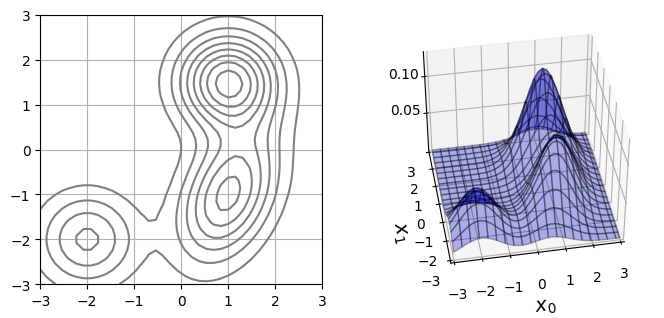

In [ ]:
# ------------ 리스트 9-2-(7)
# test -----------------------------------

pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

###EM 알고리즘의 개요
가우시안 혼합 모델을 사용하여 데이터 클러스터링 수행 -> 부담률을 구함 : K-means확장한 방법

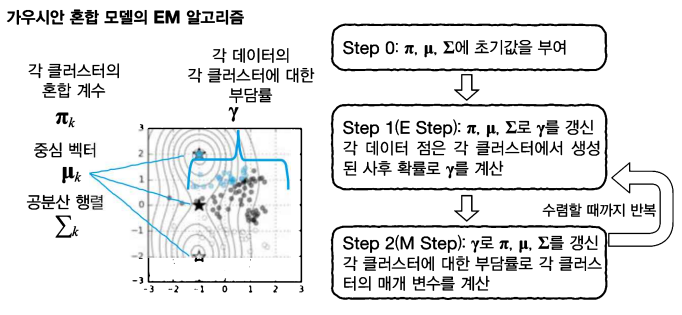

###1. 변수의 준비 및 초기화
초기값으로 할당한 중심 벡터가 인접 -> 3개의 가우스 함수가 겹쳐 세로로 긴 산과 같은 분포 표현

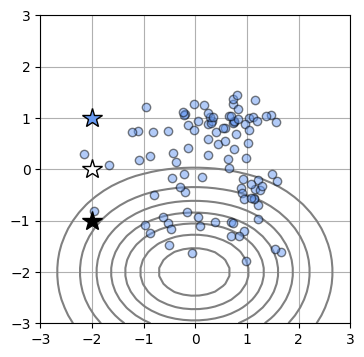

In [ ]:
# ----------------- 리스트 9-2-(8)
# 초기 설정 ------------------------------------
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ------------------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)


    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

###2. E Step 감마 갱신
각 가우스 함수의 값을 계산하고 합이 1이 되도록 규격화

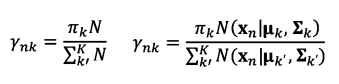

가우스 함수의 값이 높을수록 부담률도 높아진다

In [ ]:
# ----------------- 리스트 9-2-(9)
# gamma 갱신 (E Step) -------------------
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 ----------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

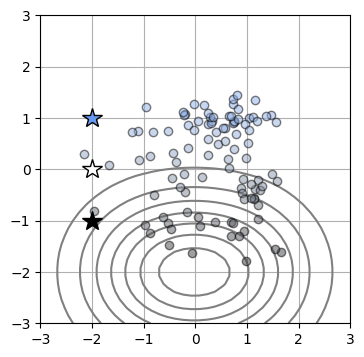

In [ ]:
# -------------- 리스트 9-2-(10)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

###3. 파이, 뮤, 시그마의 갱신
각 클러스터에 대한 부담률의 합

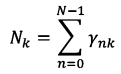

클래스에 속할 데이터의 수

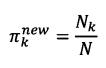

중심벡터 갱신

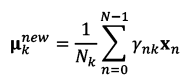

가우스의 공분산 행렬 갱신

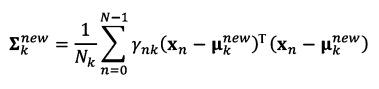

In [ ]:
# ----------------- 리스트 9-2-(11)
# Pi, Mu, Sigma 갱신 (M step) ------------
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ----------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

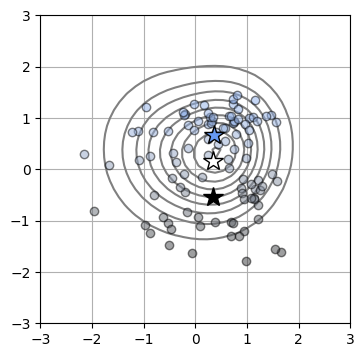

In [ ]:
# ----------------- 리스트 9-2-(12)
# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

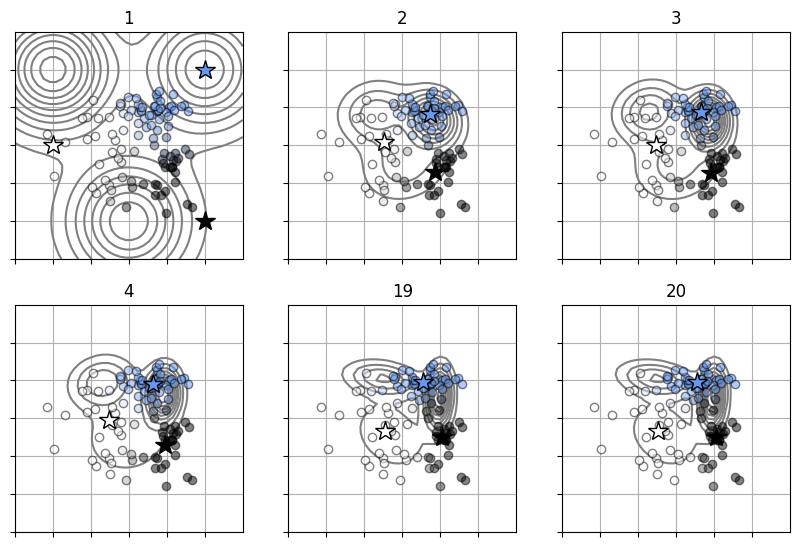

In [ ]:
# ----------------- 리스트 9-2-(13)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

클러스터링 결과는 매개 변수의 초기값에 따라 달라짐

K-means 기법의 경우에는 왜곡 척도 사용, 가우시안 혼합 모델의 경우는 가능도 사용

###가능도
입력 데이터 X는 가우시안 혼합 모델에서 생성된 것으로 생각하여, X가 생성된 확률이 가장 높도록 매개 변수 갱신


Step 10 정도에서 대부분 수렴 -> 다양한 초기값으로 클러스터링을 시도하면 가장 좋은 결과는 음의 로그 가능도가 가장 작은 것으로 판단

In [ ]:
# ----------------- 리스트 9-2-(14)
# 혼합 가우스의 목적 함수 ----------------------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


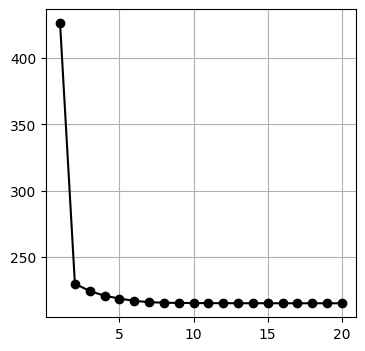

In [ ]:
# ----------------- 리스트 9-2-(15)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()

Step 10 정도에서 대부분 수렴

###After
클래스 확률을 구하기 위해 가우시안 혼합 모델을 사용한다. 이는 2차원 가우스 함수를 여러 개 합친 것이다.